# **1. REQUIRED LIBRARIES**

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np
from sklearn.preprocessing import StandardScaler
import math

# **2. BUILD THE FUNCTION** 

In [2]:
# Import the file path
file_path = 'sample_data.csv'

df = pd.read_csv(file_path)
print(f'''
Feature list:
      {df.info()}''')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10019 entries, 0 to 10018
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         10019 non-null  int64  
 1   SMILE              10019 non-null  object 
 2   ID                 10019 non-null  object 
 3   MOL                10019 non-null  object 
 4   Activity           10019 non-null  int64  
 5   MolLogP            10019 non-null  float64
 6   MolWt              10019 non-null  float64
 7   HBD                10019 non-null  int64  
 8   HBA                10019 non-null  int64  
 9   NumAromaticRings   10019 non-null  int64  
 10  NumRotatableBonds  10019 non-null  int64  
 11  TPSA               10019 non-null  float64
 12  MolMR              10019 non-null  float64
 13  BertzCT            10019 non-null  float64
 14  BalabanJ           10019 non-null  float64
 15  FpDensityMorgan1   10019 non-null  float64
 16  FpDensityMorgan2   100

In [4]:
# Fill the features that you want to do the PCA
feature_list = ['MolLogP','MolWt','HBD','HBA','NumAromaticRings','NumRotatableBonds','BalabanJ','BertzCT','HeavyAtomCount','FpDensityMorgan1']

df_prep = df[feature_list]

In [69]:
def variety_selection_pca_based(data, n_components=2, n_obs_each_corner=1, n_center_point=1):
    '''Function annatation: 
    Overall, the function performs PCA decomposition and select specific data points based on their distance to the origin point on the PCA coordinate system.

    The function takes in a prepared dataframe (df_prep) and performs PCA decomposition with a manually specified number of components. 
    It then calculates the distance of each data point to the origin point on the PCA coordinate system and uses this metric to select certain data points. 

    All observations are classified by a combination of the signs of all principal components (-1 or 1). 
    For each class, a certain number of maximum distance points are chosen as corner points. 
    
    Additionally, a certain number of minimum distance points are chosen as center points. 


    Arguments : 
    1) df_prep: a preprocessed dataset that filters out features requiring PCA decomposition.
    2) n_components: number of PCs
    3) n_obs_each_corner: number of observation on each corner of factorial desgin.
    4) n_center_point: number of center points.
    '''
    
    # Standardize data
    data_standard = StandardScaler().fit_transform(data)
    
    # Do PCA
    global df_pca
    pca = PCA(n_components=n_components)
    df_pca = pca.fit_transform(data_standard)
    df_pca = pd.DataFrame(df_pca, columns=[f'PC{i+1}' for i in range(n_components)])
    
    # Calculate distance to original PCA points
    df_pca['Distance'] = (df_pca ** 2).sum(axis=1)
    
    # Create sign columns
    for column in df_pca.columns[:-1]:
        df_pca[f'sign_{column}'] = np.sign(df_pca[column])
    
    # Groupsign and choose n_maxmum point at each corner
    global sign_columns
    sign_columns = [column for column in df_pca.columns if column.startswith('sign_')]
    df_pca = df_pca.sort_values(by=sign_columns + ['Distance'])

    max_index = df_pca.groupby(sign_columns)['Distance'].nlargest(n_obs_each_corner).index.get_level_values(-1)
    
    # Choose minimum distance as center point
    min_index = df_pca['Distance'].nsmallest(n_center_point).index.get_level_values(-1)

    # Generate final index that need to extract
    global final_index
    final_index = pd.Index(np.concatenate([max_index, min_index]))
    
    df_train = df.loc[final_index]
    df_test = df.drop(df_train.index)
    # Extract corresponding index
    return df_train, df_test

# **3. DEMO USE**

In [70]:
# Demo use
df_train, df_test = variety_selection_pca_based(data=df_prep, n_components=2, n_obs_each_corner=2,n_center_point=2)
df_train

,Unnamed: 0,SMILE,ID,MOL,Activity,MolLogP,MolWt,HBD,HBA,NumAromaticRings,...,MolMR,BertzCT,BalabanJ,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,FractionCSP3,HeavyAtomCount,HeavyAtomWt,RingCount
8768,8768,c1cccc(c12)ccc(c2)S(=O)(=O)N(C(=O)c3ccc(C)cc3)...,3461-2887nan,<rdkit.Chem.rdchem.Mol object at 0x143b32490>,0,6.44114,497.572,0,5,5,...,140.0778,1765.394109,1.735664,0.805556,1.500000,2.194444,0.103448,36,474.388,5
1759,1759,c1cccc(c12)ccc(n2)/C=C/c3ccc(cc3)/C=C/c(n4)ccc...,S966479nan,<rdkit.Chem.rdchem.Mol object at 0x143a7cf20>,0,7.12380,384.482,0,2,5,...,127.7840,1270.904044,1.301115,0.400000,0.833333,1.300000,0.000000,30,364.322,5
1200,1200,c1cccc(c12)oc(=O)c(c2)C(=O)CSc3nc(N)c(C#N)c(c3...,AG-690/12888554nan,<rdkit.Chem.rdchem.Mol object at 0x143a85850>,0,5.73456,544.592,1,9,5,...,151.8279,1871.553030,1.417816,0.950000,1.650000,2.375000,0.064516,40,524.432,5
1102,1102,c1ccc(OC)cc1NS(=O)(=O)c2c(NCc3ccc(cc3)OC)ccc(c...,K659-0717nan,<rdkit.Chem.rdchem.Mol object at 0x143a46ce0>,0,5.07910,586.714,2,7,4,...,165.1237,1620.746547,1.389141,0.785714,1.500000,2.190476,0.218750,42,552.442,5
5134,5134,N#CC(=O)CC(C)C,R260371nan,<rdkit.Chem.rdchem.Mol object at 0x1439d20a0>,0,1.12518,111.144,0,2,0,...,30.0750,120.980450,3.440210,1.750000,2.250000,2.375000,0.666667,8,102.072,0
4953,4953,FC(F)(F)[C@](F)(C(=O)N)OCC,BTB12428.0,<rdkit.Chem.rdchem.Mol object at 0x1439fd0e0>,0,0.73630,189.108,1,2,0,...,30.7144,180.777258,4.745237,1.416667,1.833333,1.916667,0.800000,12,182.052,0
4032,4032,[H]\N=C(N)\SCCN,R580147nan,<rdkit.Chem.rdchem.Mol object at 0x143a67a00>,0,-0.42823,119.193,3,3,0,...,33.4265,84.597721,3.116653,2.000000,2.714286,3.142857,0.666667,7,110.121,0
4615,4615,C1[NH+]=CN=C1C(=O)O,5132258nan,<rdkit.Chem.rdchem.Mol object at 0x143a03b50>,0,-2.36550,113.096,2,2,0,...,26.9645,170.877124,2.641840,2.000000,2.750000,3.000000,0.250000,8,108.056,1
402,402,Clc1ccc(cc1)S(=O)(=O)[N+]2=NC(=NC2SC)c3occc3,6529-0260nan,<rdkit.Chem.rdchem.Mol object at 0x143a577d0>,0,3.19340,356.836,0,6,2,...,83.8742,843.165292,2.029711,1.272727,2.000000,2.590909,0.153846,22,345.748,3
1298,1298,c1cccc(c12)c(c(c(o2)=O)N)NCCc3ccccc3,AH-262/31958008nan,<rdkit.Chem.rdchem.Mol object at 0x143a403c0>,0,3.02980,280.327,2,4,3,...,85.5321,809.883098,1.862474,1.000000,1.714286,2.523810,0.117647,21,264.199,3


# **4. TEST FUNCTION**

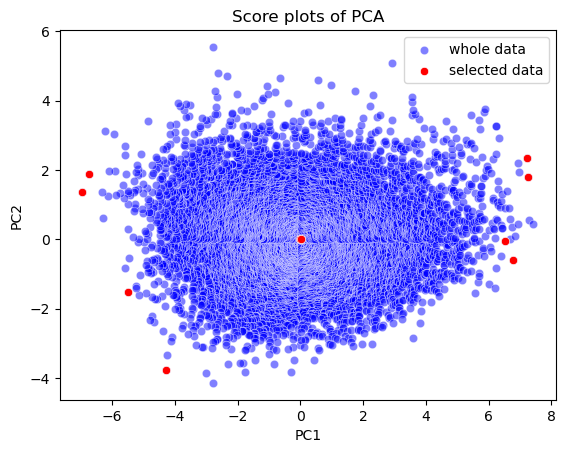

In [76]:
# Check the distribution of training dat 
df_train, df_test = variety_selection_pca_based(data=df_prep, n_components=2, n_obs_each_corner=2,n_center_point=2)

df_pca_train = df_pca.loc[final_index]

sns.scatterplot(x='PC1',y='PC2',data=df_pca,color='blue',label='whole data',alpha=0.5)
sns.scatterplot(x='PC1',y='PC2',data=df_pca_train,color='red',label='selected data')
plt.title('Score plots of PCA')
plt.legend()
plt.show()

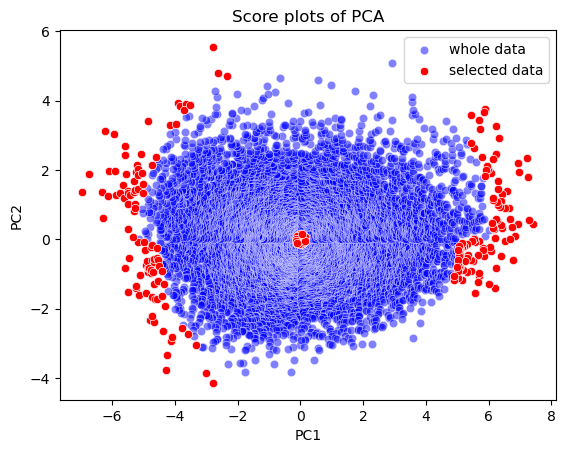

In [79]:
# Check the distribution of training dat 
df_train, df_test = variety_selection_pca_based(data=df_prep, n_components=2, n_obs_each_corner=50,n_center_point=50)

df_pca_train = df_pca.loc[final_index]

sns.scatterplot(x='PC1',y='PC2',data=df_pca,color='blue',label='whole data',alpha=0.5)
sns.scatterplot(x='PC1',y='PC2',data=df_pca_train,color='red',label='selected data')
plt.title('Score plots of PCA')
plt.legend()
plt.show()